In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
import math

In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

Create the dataset:

In [3]:
def create_multi_gaussian_mixtures(D, D2, noise, N):
    """
    Create the Gaussian mixture dataset
    :param D: number of dimensions: (x1, x2, 0, .., 0) in R^D
    :param D2: number of non-zero features
    :param noise: intensity of the random noise (mean 0)
    :param N: number of elements to generate
    :return: dataset
    """
    if N % 4 != 0:
        raise ValueError("The number of elements within the dataset must be a multiple of 4")
    if D < 2:
        raise ValueError("The number of dimensions must be at least 2")
    if noise < 0:
        raise ValueError("Signal to noise ratio must be > 0")

    X = np.zeros((N, D))
    Y = np.zeros((N,))
    for i in range(N):
        x_relevant = np.random.choice([-1.0, 1.0], size=(D2,), replace=True)
        Y[i] = np.product(x_relevant)
        x_relevant += np.random.uniform(-noise, noise, size=(D2,))
        x_trash = np.zeros(shape=(D - D2,))
        X[i] = np.concatenate([x_relevant, x_trash])
    return X, Y

Create the oracle:

In [4]:
def oracle(x_list, D2):
    return np.array([np.sign(np.prod(x[:D2])) for x in x_list])

Create the neural network of two layers, train for 1000 epochs and calculate accuracy. Such a model has $D \times hn + hn \times hn + hn \times 1$ weight parameters and $hn + hn + 1$ bias parameters, where $hh$ is the number of hidden neurons and fixed to be $\sqrt{D}$. 

In [5]:
def testing_accuracy_neural_network(X_train, X_test, y_train, y_test):
    D = len(X_train[0])
    nn = MLPClassifier(hidden_layer_sizes=(int(np.sqrt(D)), int(np.sqrt(D)), ), max_iter=10000)
    nn.fit(X_train, y_train)
    accuracy = np.average(nn.predict(X_test) == y_test)
    return accuracy

This is how a neural network can be used:

In [6]:
def run_example_nn():
    n = 7
    D = 16
    nn = MLPClassifier(hidden_layer_sizes=(int(np.sqrt(D)), int(np.sqrt(D)), ), max_iter=10000)
    X = np.random.normal(size=(n, D))
    y = np.random.choice([-1.0, 1.0], size=(n,), replace=True)
    nn.fit(X, y)
    print("NN weights: ", [c.shape for c in nn.coefs_])
    print("NN biases: ", [c.shape for c in nn.intercepts_])

Create the random feature kernel:

In [7]:
def testing_accuracy_random_kernel(X_train, X_test, y_train, y_test):
    
    D = len(X_train[0])
    h = int(np.sqrt(D))
    D_nn = (D*h + h*h + h * 1) + (h + h + 1) # weights + bias
    W = np.random.normal(size=(math.ceil(D_nn/D), D))
    
    def k(X1, X2):
        if X2 is None: 
            X2 = X1
        F1 = np.array([W.dot(x) for x in X1])
        F1 = np.maximum(F1, np.zeros(shape=F1.shape))
        F2 = np.array([W.dot(x) for x in X2])
        F2 = np.maximum(F2, np.zeros(shape=F2.shape))
        # print(F1.shape, F2.shape)
        return F1.dot(F2.T)
    
    rksvm = SVC(kernel=k)
    rksvm.fit(X_train, y_train)
    accuracy = np.average(rksvm.predict(X_test) == y_test)
    return accuracy

Compare the performances of the three approaches:

In [8]:
def compare_performances(X_train, X_test, y_train, y_test):
    oracle_accuracy = np.average(oracle(X_test, 3) == y_test)
    rk_accuracy = np.max([testing_accuracy_random_kernel(X_train, X_test, y_train, y_test) for _ in range(10)])
    nn_accuracy = np.max([testing_accuracy_neural_network(X_train, X_test, y_train, y_test) for _ in range(10)])
    return oracle_accuracy, nn_accuracy, rk_accuracy    

In [9]:
def compare_performances_d_epsilon(d):
    
    df = pd.DataFrame(columns=['noise', 'type', 'value', 'oracle', 'delta'])
    
    EPSILON = [0.1 * i for i in range(20+1)]
    for epsilon in EPSILON:
        print("Evaluating noise", epsilon)
        for r in range(10):
            X, y = create_multi_gaussian_mixtures(d, 3, epsilon, 16*d)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
            or_acc, nn_acc, rk_acc = compare_performances(X_train, X_test, y_train, y_test)
            df.loc[len(df)] = {
                'noise': epsilon,
                'type': 'Neural Network', 
                'value': nn_acc,
                'oracle': or_acc,
                'delta': or_acc - nn_acc
            }
            df.loc[len(df)] = {
                'noise': epsilon,
                'type': 'Random Feature Kernel', 
                'value': rk_acc,
                'oracle': or_acc,
                'delta': or_acc - rk_acc
            }
    
    return df

In [33]:
# df_4 = compare_performances_d_epsilon(4)
# df_8 = compare_performances_d_epsilon(8)
# df_12 = compare_performances_d_epsilon(12)
# df_16 = compare_performances_d_epsilon(16)
# df_20 = compare_performances_d_epsilon(20)
# df_24 = compare_performances_d_epsilon(24)
df_4  = pd.read_pickle("df_4.pickle")
df_8  = pd.read_pickle("df_8.pickle")
df_12 = pd.read_pickle("df_12.pickle")
df_16 = pd.read_pickle("df_16.pickle")
df_20 = pd.read_pickle("df_20.pickle")
df_24 = pd.read_pickle("df_24.pickle")

In [23]:
df_4.to_pickle("df_4.pickle")
df_8.to_pickle("df_8.pickle")
df_12.to_pickle("df_12.pickle")
df_16.to_pickle("df_16.pickle")
df_20.to_pickle("df_20.pickle")
df_24.to_pickle("df_24.pickle")

In [ ]:
def change(df_current):
    for i in df_current.index:
        if df_current.at[i, 'type'] == "Random Feature Kernel":
            df_current.at[i, 'value'] = df_current.at[i, 'oracle'] - df_current.at[i, 'delta']
change(df_8)
change(df_12)
change(df_16)
change(df_20)
change(df_24)

In [83]:
def plot_accuracy(df_current, title):
    rows_oracle = df_current[df_current["type"]=="Neural Network"].copy()
    rows_oracle["type"] = "Oracle"
    rows_oracle["value"] = rows_oracle["oracle"]
    df_current_2 = pd.concat([df_current, rows_oracle])
    
    ax = sns.pointplot(data=df_current_2, x="noise", y="value", hue="type", hue_order=["Random Feature Kernel", "Neural Network", "Oracle"])
    ax.set_xlabel('Noise ($\epsilon$)', fontsize=18)
    ax.set_ylabel('Accuracy (higher is better)', fontsize=18)
    ax.set_xticks([i * 5 for i in range(4+1)])
    ax.set_xticklabels([f"{t:0.2f}" for t in [0, 0.5, 1.0, 1.5, 2.0]], fontsize=14)
    ax.set_yticks([0.5, 0.75, 1.0])
    ax.set_yticklabels([f"{t:0.2f}" for t in [0.5, 0.75, 1.0]], fontsize=14)
    ax.set_title(title, fontsize=24)
    plt.legend(loc=3, prop={'size': 16})

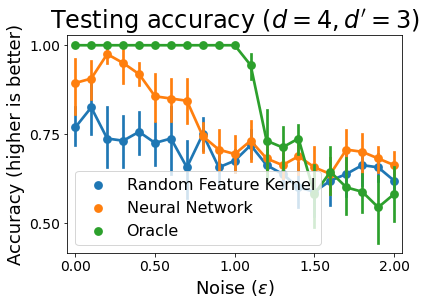

In [84]:
plot_accuracy(df_4, "Testing accuracy ($d=4, d'=3$)")

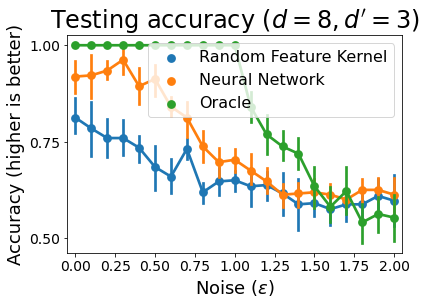

In [71]:
plot_accuracy(df_8, "Testing accuracy ($d=8, d'=3$)")

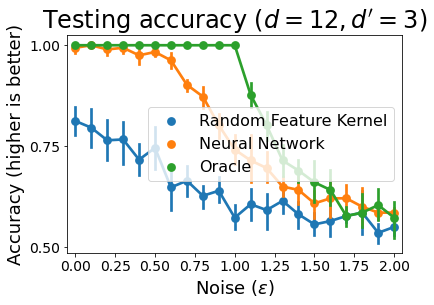

In [72]:
plot_accuracy(df_12, "Testing accuracy ($d=12, d'=3$)")

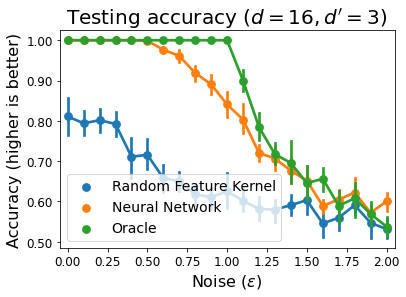

In [64]:
plot_accuracy(df_16, "Testing accuracy ($d=16, d'=3$)")

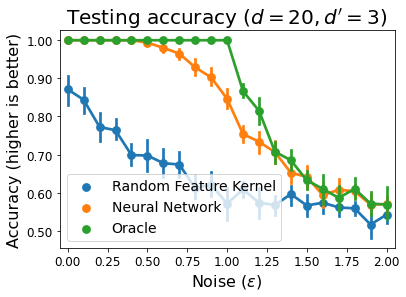

In [65]:
plot_accuracy(df_20, "Testing accuracy ($d=20, d'=3$)")

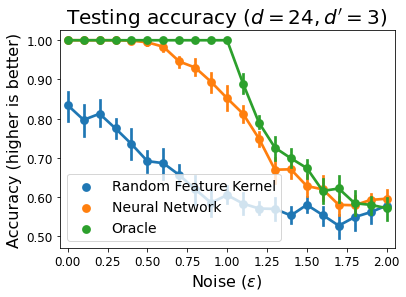

In [66]:
plot_accuracy(df_24, "Testing accuracy ($d=24, d'=3$)")